# Setup

This notebook is an excercise in running ISOFIT in pixel mode (dynamically from python), in order to get into some configuation details.

Prerequisites:
- Run the neon.ipynb notebook succesfully - we'll use some of the outputs created from that intiial sample run

## Running Per-Pixel Retrievals

That gave us a baseline run, but its not clear what might be improved.  Let's load up some individual retrievals so we can understand the performance a bit better. 
To get started with executing ISOFIT for iterable improvements, ISOFIT is comprised of three primary pieces:

1. The `ForwardModel` object
2. The `IO` object
2. The `Inverse` object

There is also an `Isofit` object that holds each of the other three, and is commonly used for more generic runs (it is what is called by apply_oe).

In [6]:
from isofit.core.isofit import Isofit
from isofit.core.fileio import IO
from isofit.core.forward import ForwardModel
from isofit.inversion.inverse import Inversion
from isofit.inversion.inverse_simple import invert_algebraic
from isofit.configs import configs
from isofit.core.geometry import Geometry

import os
import logging
import numpy as np
from spectral.io import envi
import matplotlib.pyplot as plt
%matplotlib inline

# Enable the ISOFIT logger
logging.getLogger().setLevel(logging.INFO)


In [9]:

# Find where we're running the tutorial from
home = os.path.abspath(os.getcwd())
output = os.path.join(home,'outputs')
output_surface_file = os.path.join(output, 'surface.mat')
neon_id = '173647' #one of 173647, 174150
roi = report[neon_id]
indata = os.path.join(home, 'data') 

# Now run actual retrievals
config = configs.create_new_config(os.path.join(output,f'NIS01_20210403_{neon_id}','config',f'NIS01_20210403_{neon_id}_isofit.json')) 
config.forward_model.surface.surface_file = output_surface_file
#model = Isofit(os.path.join(output,f'NIS01_20210403_{neon_id}','config',f'NIS01_20210403_{neon_id}_isofit.json'))
config.input.measured_radiance_file = os.path.join(indata,f'NIS01_20210403_{neon_id}_rdn_ort')
config.input.obs_file = os.path.join(indata,f'NIS01_20210403_{neon_id}_rdn_obs_ort')
config.input.loc_file = os.path.join(indata,f'NIS01_20210403_{neon_id}_loc_ort')

fm = ForwardModel(config)
io = IO(config, fm)
inv = Inversion(config, fm)

INFO:root:Loading config file: /Users/brodrick/repos/isofit-tutorials/isotuts/NEON/outputs/NIS01_20210403_173647/config/NIS01_20210403_173647_isofit.json
INFO:/Users/brodrick/repos/isofit/isofit/radiative_transfer/radiative_transfer_engine.py:Loading from wavelength_file: /Users/brodrick/repos/isofit-tutorials/isotuts/NEON/outputs/NIS01_20210403_173647/data/wavelengths.txt
INFO:/Users/brodrick/repos/isofit/isofit/radiative_transfer/radiative_transfer_engine.py:Prebuilt LUT provided
INFO:/Users/brodrick/repos/isofit/isofit/radiative_transfer/radiative_transfer_engine.py:Resampling LUT to instrument spectral response.


Now that we have the basic setup, we can run some retrievals.

In [14]:
region = 'Veg'
offsets = {}
miny = np.min([np.min([i[0],i[1]]) for k,i in report[neon_id].items()])-5
maxy = np.max([np.max([i[0],i[1]]) for k,i in report[neon_id].items()])+5
minx = np.min([np.min([i[2],i[3]]) for k,i in report[neon_id].items()])-5
maxx = np.max([np.max([i[2],i[3]]) for k,i in report[neon_id].items()])+5
offsets[neon_id] = [minx,miny]
adj_roi = [roi[region][0] - offsets[neon_id][1], roi[region][1] - offsets[neon_id][1], roi[region][2] - offsets[neon_id][0], roi[region][3] - offsets[neon_id][0]]

rdn = np.mean(envi.open(config.input.measured_radiance_file + '.hdr').open_memmap(interleave='bip')[adj_roi[0]:adj_roi[1],adj_roi[2]:adj_roi[3],:].copy(),axis=(0,1))
obs = np.mean(envi.open(config.input.obs_file + '.hdr').open_memmap(interleave='bip')[adj_roi[0]:adj_roi[1],adj_roi[2]:adj_roi[3],:].copy(),axis=(0,1))
loc = np.mean(envi.open(config.input.loc_file + '.hdr').open_memmap(interleave='bip')[adj_roi[0]:adj_roi[1],adj_roi[2]:adj_roi[3],:].copy(),axis=(0,1))

geom = Geometry(obs=obs,loc=loc)
states = inv.invert(rdn, geom)

x_surface, x_RT, x_instrument = fm.unpack(states[-1,:])

x_alg, Ls, coeffs = invert_algebraic(fm.surface, fm.RT, fm.instrument, 
                           x_surface, x_RT, x_instrument,
                           rdn, geom,
                           )


(12, 428)
[0.11728845 0.61252989]


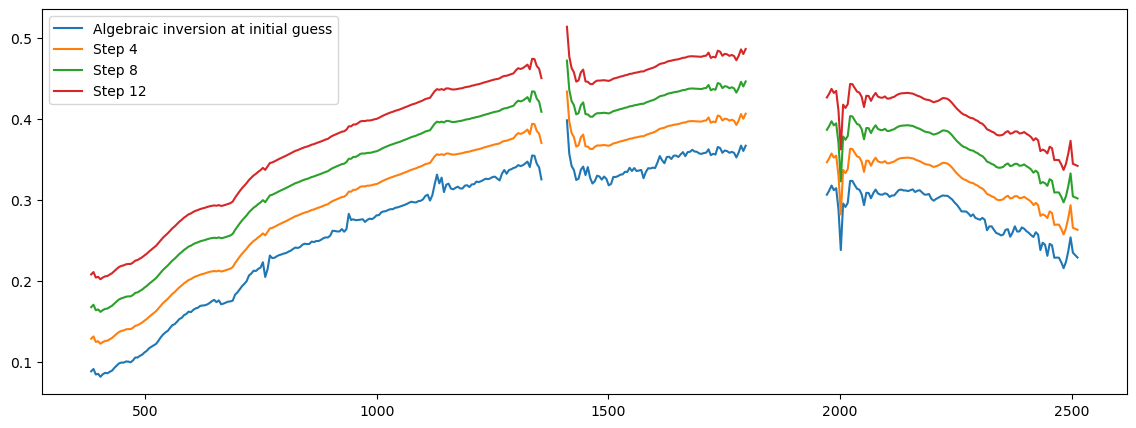

In [26]:
def closest_wl(mv):
    return np.argmin(np.abs(io.meas_wl-mv))

wl_nan = io.meas_wl.copy()
wl_nan[closest_wl(1360):closest_wl(1410)] = np.nan
wl_nan[closest_wl(1800):closest_wl(1970)] = np.nan

fig = plt.figure(figsize=(14,5))
print(states.shape)
offset = 0
for n in range(0,states.shape[0],4):
    lab = f'Step {n}'
    if n == 0:
        lab = 'Algebraic inversion at initial guess'
    
    plt.plot(wl_nan, states[n,:-2] + offset, label=lab)
    offset += 0.04
plt.plot(wl_nan, states[-1,:-2] + offset, label=f'Step {states.shape[0]}')
plt.legend()

print(states[-1,-2:])